# Book recommnedation

In [ ]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

In [ ]:
# Add some convenience functions to Pandas DataFrame.
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

# Install spreadsheets and import authentication module.
USER_RATINGS = False
!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

Installing Altair...
  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-bh410ib2
  Running command git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-bh410ib2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for altair: filename=altair-4.2.0.dev0-cp36-none-any.whl size=730019 sha256=54c02165fc841c58d685c90fa40682469ba96809dcfba2ab901fb03d0608e42a
  Stored in directory: /tmp/pip-ephem-wheel-cache-oivbshq2/wheels/01/fd/91/025b6149b3949af76e93b3b3ceca5bf12cbdebc98fa46f9ec6
Successfully built altair
Done installing Altair.


In [ ]:
users_ratings_df=pd.read_csv('users_ratings_df.csv')

In [ ]:
users_ratings_df.sample(3)

,users,The Hitchhiker's Guide To The Galaxy,Watership Down,The Five People You Meet in Heaven,Speak,I Know Why the Caged Bird Sings,Thirteen Reasons Why,Foundation Series,The Sisterhood of the Travelling Pants,A Great and Terrible Beauty,The Da Vinci Code,The Princess Diaries,Ender's Game,The Hunt for Red October,The Hunger Games,The Great Gatsby,Ranger's Apprentice Series,Inkheart,Neuromancer,Lord of the Flies,The Princess Bride,Dinotopia: A Land Apart from Time,Far North,Practical Magic,Brave New World,The Summer Tree,Flowers For Algernon,Owl in Love,Naruto,Bleach (graphic novel),Kiss the Dust,To Kill a Mockingbird,The Lion the Witch and the Wardrobe,The Bourne Series,Life of Pi,Breathless,Twilight Series,Sabriel,Nineteen Eighty-Four (1984),Eragon,Hatchet,My Sister's Keeper,The Golden Compass,Harry Potter Series,Holes,Shonen Jump Series,The Shadow Club,Bone Series,Maus: A Survivor's Tale,The Joy Luck Club,The Lord of the Rings,The Hobbit,Shattered,The War Of The Worlds,Dealing with Dragons,The Chrysalids
54,McLean,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,3,0,0,0,0,0,0,5,0,0,0,0,0,0,5,0,0,3,0,0,0,5,5,0,0,0,5,5,0,0,0,0,0,0,5,0,1,0,5
53,Don Wang,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,3,0,0,0,3,3,0,0,0,0,0,0,3,0,0,0,0
2,Reuven,5,-5,0,0,0,0,-3,-5,0,1,-5,5,0,1,0,1,-3,1,-5,0,0,0,0,0,0,3,0,0,0,0,-5,1,0,1,0,-5,0,3,-3,3,0,1,5,1,0,0,0,0,0,1,3,1,5,1,3


In [ ]:
users_ratings_df.set_index("users", drop = True, inplace = True)

In [ ]:
long_format_df=users_ratings_df.stack().reset_index()

In [ ]:
long_format_df.sample(5)

,users,level_1,0
3078,Shannon,Dealing with Dragons,0
1147,crom,Maus: A Survivor's Tale,0
3498,NaRwHaLs,Life of Pi,-5
3358,Albus Dumbledore,Speak,0
114,Reuven,I Know Why the Caged Bird Sings,0


In [ ]:
long_format_df.columns = ['users', 'book', 'rating']

In [ ]:
long_format_df['rating']=long_format_df['rating'].map({-5:1,-3:2,1:3,3:4,5:5,0:0})

In [ ]:
long_format_df['rating'].value_counts()

0    3634
5     402
4     339
3     202
1      78
2      75
Name: rating, dtype: int64

In [ ]:
user_list=list(long_format_df.users.unique())
user_mapping_dict = { user_list[i]: i+1  for i in range(len(user_list))}
book_list=list(long_format_df.book.unique())
book_mapping_dict = { book_list[i]: i+1  for i in range(len(book_list))}
long_format_df['user_id']=long_format_df.users.map(user_mapping_dict)
long_format_df['book_id']=long_format_df.book.map(book_mapping_dict)

In [ ]:
long_format_df

,users,title,rating,user_id,movie_id
0,Ben,The Hitchhiker's Guide To The Galaxy,5,1,1
1,Ben,Watership Down,0,1,2
2,Ben,The Five People You Meet in Heaven,0,1,3
3,Ben,Speak,0,1,4
4,Ben,I Know Why the Caged Bird Sings,0,1,5
...,...,...,...,...,...
4725,Megan,The Hobbit,5,85,51
4726,Megan,Shattered,0,85,52
4727,Megan,The War Of The Worlds,5,85,53
4728,Megan,Dealing with Dragons,0,85,54


In [ ]:
long_format_df.rename({'book':'title','book_id':'movie_id'},axis=1,inplace=True)

In [ ]:
users=long_format_df[['user_id']]
movies=long_format_df[['movie_id','title']]
#users.drop_duplicates(inplace=True)
#movies.drop_duplicates(inplace=True)
print(users.shape)
print(movies.shape)

(4730, 1)
(4730, 2)


In [ ]:
long_format_df=long_format_df[['user_id','movie_id','rating']]
long_format_df=long_format_df[long_format_df['rating']!=0]
long_format_df.head()

,user_id,movie_id,rating
0,1,1,5
7,1,8,3
9,1,10,3
10,1,11,2
11,1,12,5


In [ ]:
long_format_df.shape

(1096, 3)

In [ ]:
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = ratings_df[['user_id', 'movie_id']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

In [ ]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

In [ ]:
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [ ]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "movie_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

In [ ]:
# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [ ]:
long_format_df.columns=['user_id','movie_id','rating']
long_format_df.head()

,user_id,movie_id,rating
0,1,1,5
7,1,8,3
9,1,10,3
10,1,11,2
11,1,12,5


 iteration 1000: train_error=0.000151, test_error=5.693798

[{'test_error': 5.693798, 'train_error': 0.00015140868}]

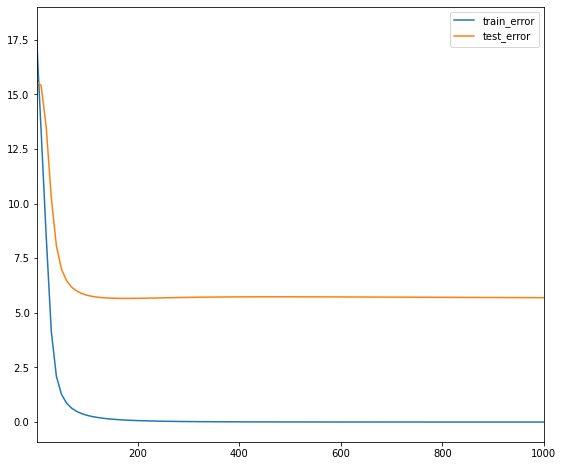

In [ ]:
# Build the CF model and train it.
model = build_model(long_format_df, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=0.5)

In [ ]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [ ]:
def user_recommendations(model, measure=DOT, exclude_rated=False, k=6):
  if USER_RATINGS:
    scores = compute_scores(
        model.embeddings["user_id"][943], model.embeddings["movie_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'movie_id': movies['movie_id'],
        'titles': movies['title'],
        'genres': movies['all_genres'],
    })
    if exclude_rated:
      # remove movies that are already rated
      rated_movies = ratings[ratings.user_id == "943"]["movie_id"].values
      df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
    display.display(df.sort_values([score_key], ascending=False).head(k))  

def movie_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for movie ids that match the given substring.
  ids =  movies[movies['title'].str.contains(title_substring)].index.values
  titles = movies.iloc[ids]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no movies with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching movie. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  movie_id = ids[0]
  scores = compute_scores(
      model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': movies['title'],
      # 'genres': movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

In [ ]:
movie_neighbors(model, "Watership Down", DOT)
movie_neighbors(model, "Watership Down", COSINE)

Nearest neighbors of : Watership Down.
[Found more than one matching movie. Other candidates: Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership 

,dot score,titles
1,13.781,Watership Down
2,8.825,The Five People You Meet in Heaven
3,8.350,Speak
4182,7.712,The Five People You Meet in Heaven
629,7.254,The Summer Tree
2798,7.055,The Joy Luck Club


Nearest neighbors of : Watership Down.
[Found more than one matching movie. Other candidates: Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership Down, Watership 

,cosine score,titles
1,1.000,Watership Down
2,0.715,The Five People You Meet in Heaven
629,0.685,The Summer Tree
4182,0.633,The Five People You Meet in Heaven
3,0.624,Speak
3022,0.571,The War Of The Worlds
